In [220]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [221]:
train = pd.read_csv('/home/vorstrel/study/data/titanic/train.csv')
test = pd.read_csv('/home/vorstrel/study/data/titanic/test.csv')

In [222]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [223]:
X_train = pd.get_dummies(
    train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']],
    columns=['Sex', 'Embarked']
)
X_test = pd.get_dummies(
    test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']],
    columns=['Sex', 'Embarked']
)

In [224]:
y_train = train['Survived']

In [225]:
imp = Imputer(strategy='most_frequent')
X_train_imp = imp.fit_transform(X_train)
X_test_imp = imp.transform(X_test)

# Cross-validation

In [226]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=4, shuffle=True, random_state=200)

scores = cross_val_score(DecisionTreeClassifier(),
                         X_train_imp, y_train, groups=None,
                         scoring = make_scorer(accuracy_score),
                         cv = kfold
                        )

In [227]:
np.average(scores)

0.77890053730860909

# Optimize model

In [228]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
        'model':[DecisionTreeClassifier(presort=True)],
        'model__max_features':range(1, len(X_train.columns) + 1),
        'model__max_depth':range(1, 10),
}

pipeline = Pipeline([
    ('model', None),
])

grid = GridSearchCV(pipeline, param_grid, 
                    scoring=make_scorer(accuracy_score),
                    cv=kfold)

In [229]:
model = grid.fit(X_train_imp, y_train)

In [230]:
model.best_params_

{'model': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
             max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=True, random_state=None,
             splitter='best'), 'model__max_depth': 5, 'model__max_features': 6}

In [231]:
model.score(X_train_imp, y_train)

0.84624017957351294

## Feature importance

In [232]:
from matplotlib import pyplot as plt
%matplotlib inline

''

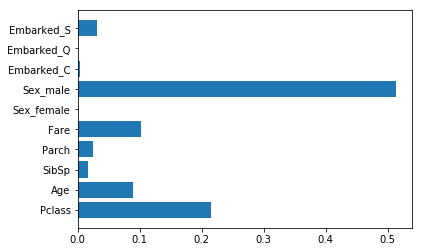

In [233]:
plt.barh(
    np.arange(len(model.best_params_['model'].feature_importances_)),
    model.best_params_['model'].feature_importances_
)
plt.yticks(np.arange(len(X_train.columns)),X_train.columns)
''

### Самыми важными фичами, как видим, являются пол, стоимость билета (Fare), возраст и класс

In [234]:
model.best_params_['model']

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=6, max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=True, random_state=None,
            splitter='best')

In [239]:
from sklearn.tree import export_graphviz

print(
    export_graphviz(
        model.best_params_['model'],
        out_file=None, filled=True,
        feature_names=list(X_train.columns),
        class_names=['Died', 'Survived']
    )
)

digraph Tree {
node [shape=box, style="filled", color="black"] ;
0 [label="Pclass <= 2.5\ngini = 0.473\nsamples = 891\nvalue = [549, 342]\nclass = Died", fillcolor="#e5813960"] ;
1 [label="Sex_male <= 0.5\ngini = 0.4934\nsamples = 400\nvalue = [177, 223]\nclass = Survived", fillcolor="#399de535"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="Embarked_S <= 0.5\ngini = 0.1003\nsamples = 170\nvalue = [9, 161]\nclass = Survived", fillcolor="#399de5f1"] ;
1 -> 2 ;
3 [label="Age <= 49.5\ngini = 0.0357\nsamples = 55\nvalue = [1, 54]\nclass = Survived", fillcolor="#399de5fa"] ;
2 -> 3 ;
4 [label="gini = 0.0\nsamples = 46\nvalue = [0, 46]\nclass = Survived", fillcolor="#399de5ff"] ;
3 -> 4 ;
5 [label="Fare <= 44.0563\ngini = 0.1975\nsamples = 9\nvalue = [1, 8]\nclass = Survived", fillcolor="#399de5df"] ;
3 -> 5 ;
6 [label="gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Died", fillcolor="#e58139ff"] ;
5 -> 6 ;
7 [label="gini = 0.0\nsamples = 8\nvalue = [0, 8]\nclass

## Submission 

In [240]:
predicted = model.predict(imp.transform(X_test))

In [241]:
with open('submission.txt', 'w') as out:
    out.write('PassengerId,Survived\n')
    for passenger, y in zip(test['PassengerId'], predicted):
        out.write('%s,%s\n' % (passenger, y))